In [ ]:
import os
import numpy as np
import pandas as pd
from os import path
import scipy as sp
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
from resampy import resample
from librosa.display import specshow

%matplotlib inline

In [69]:
DATA_DIR = "data"

In [51]:
sr = 16000
win_length=int(sr*0.030)
hop_length=int(sr*0.005)

def plot_spec(signal, return_spec=False):
    Sxx = librosa.core.stft(
        signal,
        win_length=win_length,
        hop_length=hop_length,
        n_fft=4096
    )

    spec = librosa.amplitude_to_db(np.abs(Sxx), ref=np.max)
    specshow(
        spec,
        sr=sr,
        x_axis='time',
        y_axis='hz',
        cmap='gray_r'
    )
    plt.colorbar(format='%+2.0f dB')
    
    if return_spec:
        return spec
    

def pvsample(b, t, hop=0):
    """
    http://www.ee.columbia.edu/~dpwe/LabROSA/matlab/pvoc/
    """
    rows, cols = b.shape

    N = 2*(rows-1)

    if hop == 0:
        hop = int(N / 2)

    # Empty output array
    c = np.zeros((rows, len(t)))

    # Expected phase advance in each bin
    dphi = np.zeros((1, int(N / 2.0) + 1))
    dphi[:1 + int(N / 2.0)] = (2*np.pi*hop) / (N / np.arange(1, N / 2 + 2))

    # Phase accumulator
    # Preset to phase of first frame for perfect reconstruction
    # in case of 1:1 time scaling
    ph = np.angle(b[:,0]);

    # Append a 'safety' column on to the end of b to avoid problems 
    # taking *exactly* the last frame (i.e. 1*b(:,cols)+0*b(:,cols+1))
    b = np.hstack((b, np.zeros((rows, 1))))

    ocol = 0
    for tt in np.copy(t):
        # Grab the two columns of b
        cols = int(np.floor(tt)) + np.array([0, 1])
        bcols = b[:,cols]
        tf = tt - np.floor(tt)
        bmag = (1-tf) * np.abs(bcols[:,0]) + tf * np.abs(bcols[:,1])
        
        # calculate phase advance
        dp = np.angle(bcols[:,1]) - np.angle(bcols[:,0]) - dphi
        
        # Reduce to -pi:pi range
        dp = dp - 2 * np.pi * np.round(dp/(2*np.pi))
        
        # Save the column
        c[:, ocol] = bmag * np.exp(1j*ph)
        
        # Cumulate phase, ready for next frame
        ph = ph + dphi + dp
        ocol += 1
        
    return c


def pv(x, r=1, n=1024, sr=sr):
    """
    http://www.ee.columbia.edu/~dpwe/LabROSA/matlab/pvoc/
    """
    hop = int(n / 4.0)
    scf = 1.0
    
    f, t, X = sp.signal.stft(x, fs=sr, nfft=n, nperseg=n, noverlap=nfft-hop)
    X *= scf
    
    rows, cols = X.shape
    t = np.arange(0, cols, r)
    
    X2 = pvsample(X, t, hop)
    t, y = sp.signal.istft(X2, fs=sr, nfft=n, nperseg=n, noverlap=nfft-hop)
    return t, y


def pitch_scale(x, ratio):
    """
    Scale the pitch of x by the ratio, using the phase vocoder technique
    """
    t, x_pv = pv(x, ratio)
    return resample(x_pv, sr, int(sr * ratio))
        

In [72]:
x, sr = librosa.load('../data/clar.wav')
x = librosa.util.normalize(x)

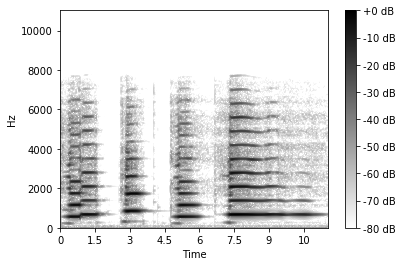

In [48]:
plot_spec(x)

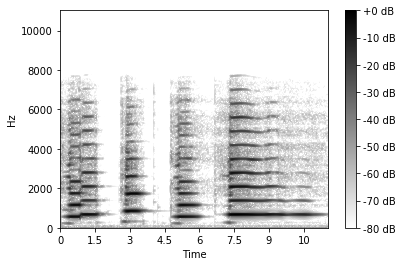

In [49]:
spec_orig = plot_spec(x, return_spec=True)
ipd.Audio(x, rate=sr)

/home/aagnone/anaconda3/envs/bob_py3/lib/python3.6/site-packages/ipykernel_launcher.py:97: ComplexWarning: Casting complex values to real discards the imaginary part


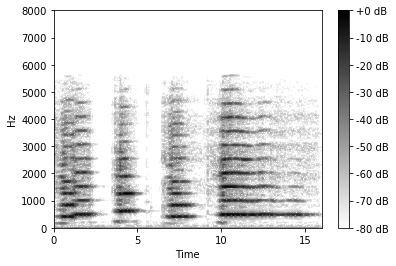

In [53]:
ratio = 1.0
x_rs2 = pitch_scale(x, ratio)

spec_rs = plot_spec(x_rs2, return_spec=True)
ipd.Audio(x_rs2, rate=sr)

/home/aagnone/anaconda3/envs/bob_py3/lib/python3.6/site-packages/ipykernel_launcher.py:97: ComplexWarning: Casting complex values to real discards the imaginary part


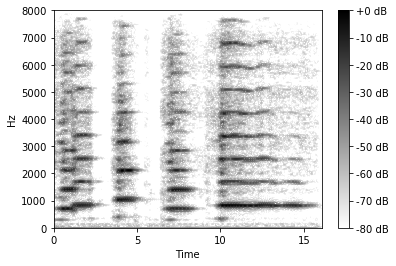

In [56]:
x_rs2 = pitch_scale(x, 3/5.)

plot_spec(x_rs2)
ipd.Audio(x_rs2, rate=sr)

/home/aagnone/anaconda3/envs/bob_py3/lib/python3.6/site-packages/ipykernel_launcher.py:97: ComplexWarning: Casting complex values to real discards the imaginary part


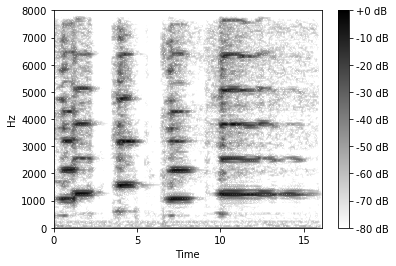

In [65]:
x_rs = pitch_scale(x, 0.4)

plot_spec(x_rs)
ipd.Audio(x_rs, rate=sr)

/home/aagnone/anaconda3/envs/bob_py3/lib/python3.6/site-packages/ipykernel_launcher.py:97: ComplexWarning: Casting complex values to real discards the imaginary part


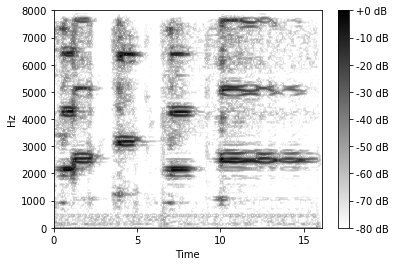

In [64]:
x_rs = pitch_scale(x, 0.2)

plot_spec(x_rs)
ipd.Audio(x_rs, rate=sr)

/home/aagnone/anaconda3/envs/bob_py3/lib/python3.6/site-packages/ipykernel_launcher.py:97: ComplexWarning: Casting complex values to real discards the imaginary part


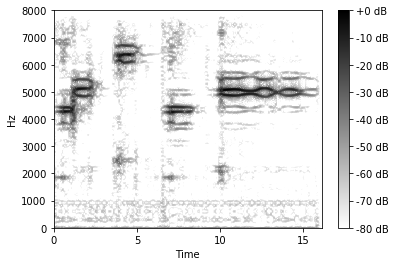

In [66]:
x_rs = pitch_scale(x, 0.1)

plot_spec(x_rs)
ipd.Audio(x_rs, rate=sr)